# McsPyDataTools Tutorial for data analysis: Spike Detection and Sorting

This tutorial gives an introduction into data analysis with the McsPyDataTools toolbox using simple algorithms for spike detection and spike sorting. Its purpose isn't to develop production grade algorithms for spike detection and sorting, but to provide a gentle start into the analysis of neuronal data files with the McsPyDataTools.

The dataset we are using in this tutorial stems from a recording with the [MCS Multiwell-MEA system](https://www.multiwell-mea.com) using a 24-well MEA plate. Due to file size constraints, only data from a single well (12 channels) is included in this data set.

First, let's import the necessary modules:

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# MCS PyData tools
import McsPy
import McsPy.McsData
from McsPy import ureg, Q_

# VISUALIZATION TOOLS
import matplotlib.pyplot as plt
%matplotlib inline

# SUPRESS WARNINGS
import warnings
warnings.filterwarnings('ignore')

# autoreload modules
%load_ext autoreload
%autoreload 2

Then, we need to define where the test data is located. This needs to be adjusted to your local setup! The McsPyDataTools toolbox includes a set of small test files in its `tests/TestData` folder. An archive with larger test files can be downloaded from the [Multi Channel DataManager](https://www.multichannelsystems.com/software/multi-channel-datamanager) page.

In [2]:
test_data_folder = r'..\McsPyDataTools\McsPy\tests\TestData' # adjust this to your local environment
file_path = os.path.join(test_data_folder, 'MultiUnitData.h5')

The data set contains 3 analog streams and 3 event streams. The following table gives a short overview over the purpose of these streams:

| **Stream**       | **Content**                         |
|------------------|-------------------------------------|
| Analog Stream 0  | Electrode Data                      |
| Analog Stream 1  | Analog In Data                      |
| Analog Stream 2  | Digital In/Out Data                 |
| Event Stream 0   | Digital In/Out Events, Stimulation Events  |
| Event Stream 1   | Experiment Timing Events            |
| Event Stream 2   | Treatment Timing Events             |

For the purposes of this tutorial, only Analog Stream 0 is relevant because it holds the recorded neuronal data. The other streams, especially the event streams, become important as soon as you are working with stimulation and need the stimulation timestamps (Event Stream 0) or if you are analyzing Multiwell-MEA data recorded from experiments with multiple phases, e.g. if recorded a dilution series for a compound. In this case, Event Stream 1 and 2 will give you the timestamps of each phase in the experiment. However, because only a single phase was recorded here and no stimulation was used, Analog Stream 0 will suffice.

In [3]:
file = McsPy.McsData.RawData(file_path)
electrode_stream = file.recordings[0].analog_streams[0];

Recording_0 <HDF5 group "/Data/Recording_0" (2 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (12, 13245000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (12,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (8, 13245000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (8,), type "|V108">
Stream_2 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_2" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (2, 13245000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (2,), type "|V108">


## Visualization

Let's define a plot function to plot a single channel.

In [4]:
def plot_analog_stream_channel(analog_stream, channel_idx, from_in_s=0, to_in_s=None, show=True):
    """
    Plots data from a single AnalogStream channel
    
    :param analog_stream: A AnalogStream object
    :param channel_idx: A scalar channel index (0 <= channel_idx < # channels in the AnalogStream)
    :param from_in_s: The start timestamp of the plot (0 <= from_in_s < to_in_s). Default: 0
    :param to_in_s: The end timestamp of the plot (from_in_s < to_in_s <= duration). Default: None (= recording duration)
    :param show: If True (default), the plot is directly created. For further plotting, use show=False
    """
    # extract basic information
    ids = [c.channel_id for c in analog_stream.channel_infos.values()]
    channel_id = ids[channel_idx]
    channel_info = analog_stream.channel_infos[channel_id]
    sampling_frequency = channel_info.sampling_frequency.magnitude
   
    # get start and end index
    from_idx = max(0, int(from_in_s * sampling_frequency))
    if to_in_s is None:
        to_idx = analog_stream.channel_data.shape[1]
    else:
        to_idx = min(analog_stream.channel_data.shape[1], int(to_in_s * sampling_frequency))
        
    # get the timestamps for each sample
    time = analog_stream.get_channel_sample_timestamps(channel_id, from_idx, to_idx)

    # scale time to seconds:
    scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
    time_in_sec = time[0] * scale_factor_for_second
    
    # get the signal
    signal = analog_stream.get_channel_in_range(channel_id, from_idx, to_idx)

    # scale signal to µV:
    scale_factor_for_uV = Q_(1,signal[1]).to(ureg.uV).magnitude
    signal_in_uV = signal[0] * scale_factor_for_uV

    # construct the plot
    _ = plt.figure(figsize=(20,6))
    _ = plt.plot(time_in_sec, signal_in_uV)
    _ = plt.xlabel('Time (%s)' % ureg.s)
    _ = plt.ylabel('Voltage (%s)' % ureg.uV)
    _ = plt.title('Channel %s' % channel_info.info['Label'])
    if show:
        plt.show()

Then, we can have a look at different channels (feel free to play around with the channel index and the time range):

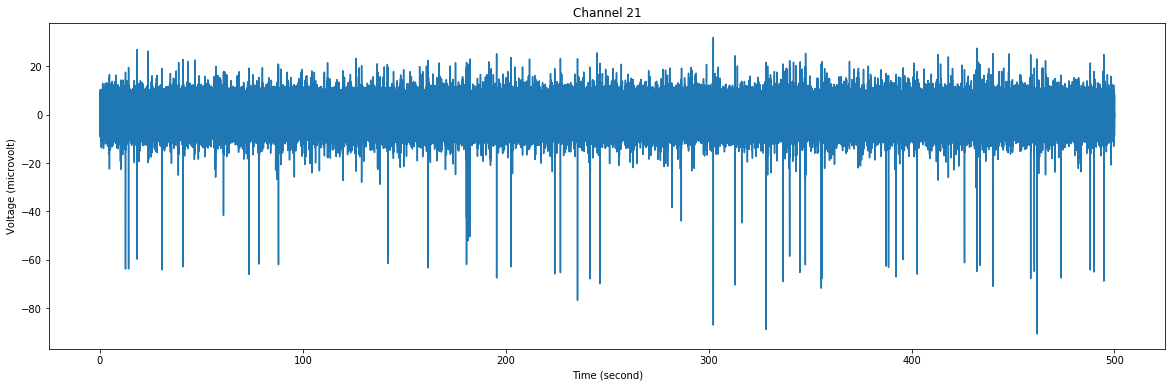

In [5]:
plot_analog_stream_channel(electrode_stream, 0, from_in_s=0, to_in_s=500)

For the purposes of this tutorial, we are going to work with the channel with index ``9`` and ID ``171``. In the MEA well, this channel was at position ``'43'``. We chose this channel because it exhibits nice multi-unit activity which is perfect for a tutorial on spike sorting. Looking at a short time segment for this channel, we can clearly see spikes of vastly different amplitudes which most likely stem from different neurons.

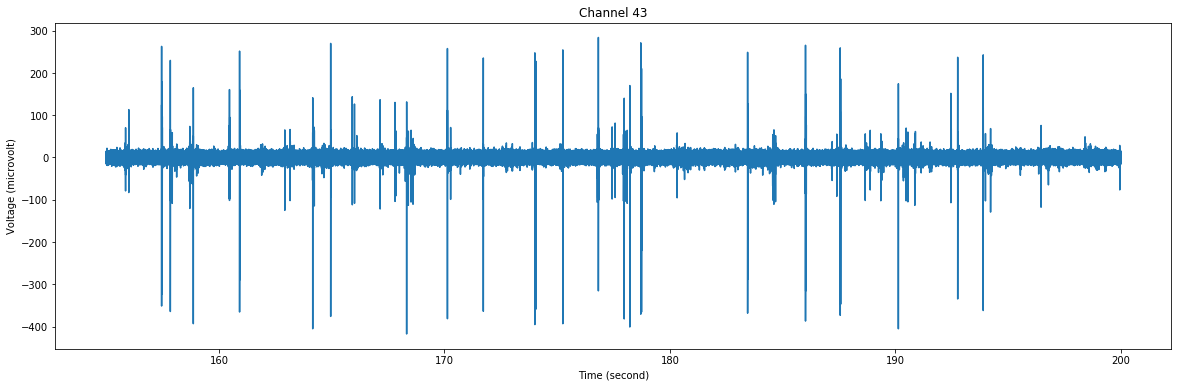

In [6]:
plot_analog_stream_channel(electrode_stream, 9, from_in_s=155, to_in_s=200)

Depending on the bandwidth of the recording, it can be necessary to perform a bandpass filtering in order to remove low-frequency fluctuations. A bandpass filter with cutoffs ``[100, 3500] Hz`` had been applied during the recording of this dataset, so no further filtering is necessary here.

In [7]:
channel_id = 171
info = electrode_stream.channel_infos[channel_id].info
print("Bandwidth: %s - %s Hz" % (info['HighPassFilterCutOffFrequency'], info['LowPassFilterCutOffFrequency']))

signal = electrode_stream.get_channel_in_range(channel_id, 0, electrode_stream.channel_data.shape[1])[0]

Bandwidth: 100 - 3500 Hz


## Spike Detection

Our first task is going to be to detect spikes on the data channel and extract cutouts of the spike waveforms. 

Usually, the easiest way to get these spike waveforms would be to perform the spike detection in the MCS software, export them together with the recorded raw data to HDF5 and then simply access them with the McsPy tools. These spike waveforms would be stored as a ``SegmentStream`` (see the basic toolbox tutorial for more information on interacting with ``SegmentStream``s).

However, for tutorial purposes, let's say we want to redo the spike detection in Python. We use a very simple threshold-based spike detection here.

First, we need to determine a suitable threshold for spike detection. A reasonable way to do this is to estimate the noise level of the channel, and then use a multiple of the noise level as the threshold (a multiplication factor of 5 tends to work quite well). While we could estimate the noise level from the standard deviation of the signal, this has the drawback that the spikes in the signal can have a strong influence on the standard deviation and lead to an unnecessarily high threshold. The MAD estimator is more robust against outlier and might therefore be more appropriate:

In [8]:
noise_std = np.std(signal)
noise_mad = np.median(np.absolute(signal)) / 0.6745
print('Noise Estimate by Standard Deviation: {0:g} V'.format(noise_std))
print('Noise Estimate by MAD Estimator     : {0:g} V'.format(noise_mad))

Noise Estimate by Standard Deviation: 8.89075e-06 V
Noise Estimate by MAD Estimator     : 5.83227e-06 V


As you can see, the difference between the two is about 3 µV, so we'll stick with the MAD estimator. We are using a negative threshold here, so we are just looking at the negative peak of each spike.

In [9]:
spike_threshold = -5 * noise_mad # roughly -30 µV

Let's plot the same data section as above together with the spike threshold. We are detecting some very small spikes with this threshold, so depending on your aim you may want to increase the multiplication factor.

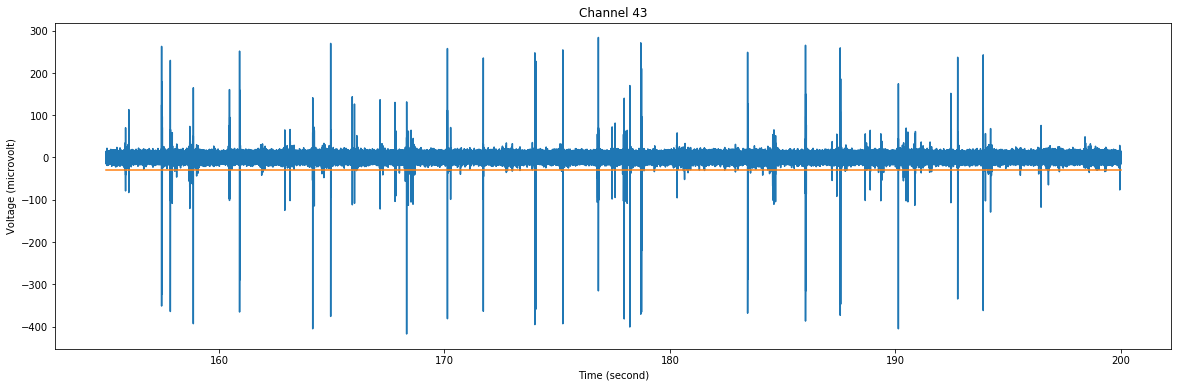

In [10]:
plot_analog_stream_channel(electrode_stream, 9, from_in_s=155, to_in_s=200, show=False)
_ = plt.plot([155, 200], [spike_threshold*1e6, spike_threshold*1e6]) # converts the threshold to µV for plotting
plt.show()

Our spike detector needs to take into account that a spike typically comprises multiple samples, so we can't simply take each sample that exceeds the threshold as an individual spike detection. Instead, we'll define a *dead time*, meaning that whenever we detect a spike, the next few samples within the dead time won't trigger a spike detection by themselves. 

In order to reduce the detection jitter, we additionally search for each spike the minimum in the signal for a short period of time after the threshold crossing. This will be the timestamp for each spike. We'll define some helper functions to achieve this:

In [11]:
def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return them as an array
    
    The signal transitions from a sample above the threshold to a sample below the threshold for a detection and
    the last detection has to be more than dead_time apart from the current one.
    
    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold: The threshold for the signal
    :param dead_time: The dead time in seconds. 
    """
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff((signal <= threshold).astype(int) > 0).nonzero()[0]
    distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    return threshold_crossings

def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index
    
    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index 
    :param max_samples_to_search: The number of samples to search for a minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx

def align_to_minimum(signal, fs, threshold_crossings, search_range):
    """
    Returns the index of the next negative spike peak for all threshold crossings
    
    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold_crossings: The array of indices where the signal crossed the detection threshold
    :param search_range: The maximum duration in seconds to search for the minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)

Now, let's perform the spike detection using our detector with dead time. Then, we align the spikes to their negative peaks.

In [12]:
fs = int(electrode_stream.channel_infos[channel_id].sampling_frequency.magnitude)
crossings = detect_threshold_crossings(signal, fs, spike_threshold, 0.003) # dead time of 3 ms
spks = align_to_minimum(signal, fs, crossings, 0.002) # search range 2 ms

To double check, let's plot the signal together with the detected spikes:

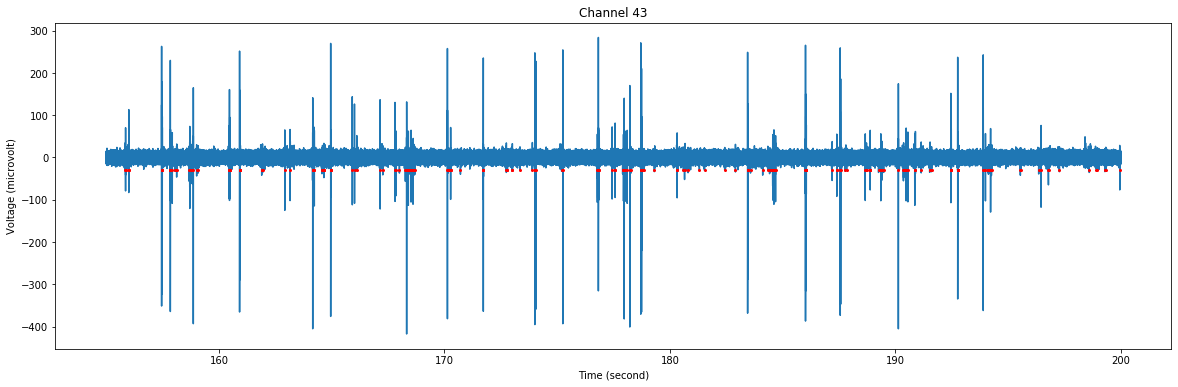

In [13]:
timestamps = spks / fs
range_in_s = (155, 200)
spikes_in_range = timestamps[(timestamps >= range_in_s[0]) & (timestamps <= range_in_s[1])]

plot_analog_stream_channel(electrode_stream, 9, from_in_s=range_in_s[0], to_in_s=range_in_s[1], show=False)
_ = plt.plot(spikes_in_range, [spike_threshold*1e6]*spikes_in_range.shape[0], 'ro', ms=2)
plt.show()

## Spike Waveforms

Having found the spike timestamps, we may now extract the spike waveforms. For this, we simply cut out a portion of the signal around each spike. Spikes too close to the start or end of the signal that a full cutout is not possible are ignored.

In [14]:
def extract_waveforms(signal, fs, spikes_idx, pre, post):
    """
    Extract spike waveforms as signal cutouts around each spike index as a spikes x samples numpy array
    
    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param spikes_idx: The sample index of all spikes as a 1-dim numpy array
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    """
    cutouts = []
    pre_idx = int(pre * fs)
    post_idx = int(post * fs)
    for index in spikes_idx:
        if index-pre_idx >= 0 and index+post_idx <= signal.shape[0]:
            cutout = signal[(index-pre_idx):(index+post_idx)]
            cutouts.append(cutout)
    return np.stack(cutouts)

In [15]:
pre = 0.001 # 1 ms
post= 0.002 # 2 ms
cutouts = extract_waveforms(signal, fs, spks, pre, post)
print("Cutout array shape: " + str(cutouts.shape)) # number of spikes x number of samples

Cutout array shape: (2579, 75)


Let's plot an overlay of the extracted cutouts:

In [16]:
def plot_waveforms(cutouts, fs, pre, post, n=100, color='k', show=True):
    """
    Plot an overlay of spike cutouts
    
    :param cutouts: A spikes x samples array of cutouts
    :param fs: The sampling frequency in Hz
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    :param n: The number of cutouts to plot, or None to plot all. Default: 100
    :param color: The line color as a pyplot line/marker style. Default: 'k'=black
    :param show: Set this to False to disable showing the plot. Default: True
    """
    if n is None:
        n = cutouts.shape[0]
    n = min(n, cutouts.shape[0])
    time_in_us = np.arange(-pre*1000, post*1000, 1e3/fs)
    if show:
        _ = plt.figure(figsize=(12,6))
    
    for i in range(n):
        _ = plt.plot(time_in_us, cutouts[i,]*1e6, color, linewidth=1, alpha=0.3)
        _ = plt.xlabel('Time (%s)' % ureg.ms)
        _ = plt.ylabel('Voltage (%s)' % ureg.uV)
        _ = plt.title('Cutouts')
    
    if show:
        plt.show()

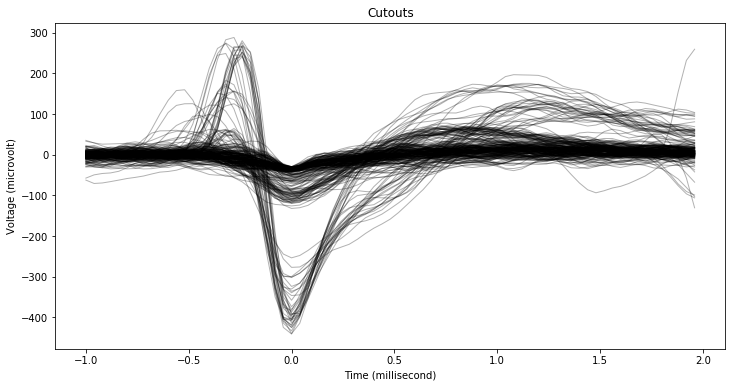

In [17]:
plot_waveforms(cutouts, fs, pre, post, n=250)

From this waveform overlay it seems clear that the spikes we are seeing stem from (at least) two different neurons. In order to determine, which spikes stem from the same neuron, we need to analyze these cutouts further. 

## Feature Extraction

We would expect that we should be able to distinguish the spikes from different neurons based on the shape of the spike waveform. So we now need a way to find a good representation of the waveform shape. "Good" means in this case that the result should be well separable, i.e. that similar waveforms are represented close to each other and far away from dissimilar waveforms. In addition, the representation should have as few dimensions as possible because the clustering step tends to work better if there aren't too many dimensions involved.

This is commonly called the *Feature Extraction* step.

We could try to manually design some features that seem useful. For example, we could take the minimum and maximum amplitude and try to work with those:

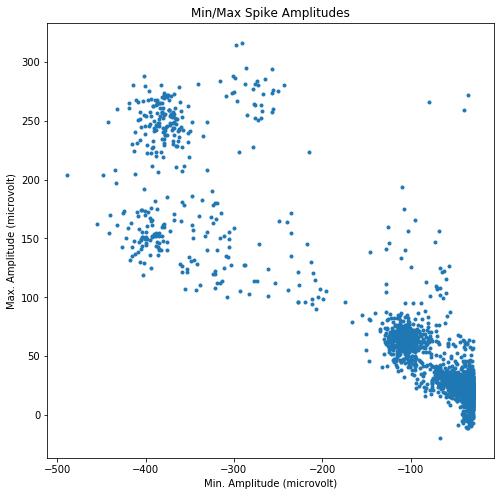

In [18]:
min_amplitude = np.amin(cutouts, axis=1)
max_amplitude = np.amax(cutouts, axis=1)

_ = plt.figure(figsize=(8,8))
_ = plt.plot(min_amplitude*1e6, max_amplitude*1e6,'.')
_ = plt.xlabel('Min. Amplitude (%s)' % ureg.uV)
_ = plt.ylabel('Max. Amplitude (%s)' % ureg.uV)
_ = plt.title('Min/Max Spike Amplitudes')

plt.show()

We can directly see some distinct clusters in this plot which might represent spikes from different neuronal sources, but a lot of spikes are closely bunched together in the lower right corner. Taking only the minimum and maximum amplitude might be a bit too simplistic, because for example judging from the cutout overlay plot, the maximum can happen before or after time point 0 and with similar values. Using the amplitude alone won't differentiate between these different shapes. 

More sophisticated feature design could remedy this, but there are also more general feature extraction methods available that require less manual interaction. A widespread method for this is principal component analysis ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)). It finds a linear transformation of the data into principal component space, thereby decorrelating the data. Because each principle component (PC) explains as much variance in the data as possible (while being orthogonal to all previous principal components), we can use the explained variance as a measure of the  "importance" of each PC. This will help us decide, how many dimensions (= PCs) we need to keep.

In [19]:
scaler = StandardScaler()
scaled_cutouts = scaler.fit_transform(cutouts)

pca = PCA()
pca.fit(scaled_cutouts)
print(pca.explained_variance_ratio_)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

[4.95861981e-01 1.86792909e-01 1.07960458e-01 4.92467665e-02
 3.92615578e-02 2.43178104e-02 1.54772580e-02 1.42838769e-02
 1.32672412e-02 9.07951432e-03 6.22540386e-03 5.76332370e-03
 5.09706162e-03 4.57872079e-03 3.37948805e-03 2.88224864e-03
 2.35134998e-03 2.00488981e-03 1.77034798e-03 1.47102577e-03
 1.18203490e-03 1.06396539e-03 9.34307355e-04 7.84827463e-04
 7.03255677e-04 6.52196920e-04 5.41354290e-04 4.90419984e-04
 4.14199911e-04 3.63004816e-04 3.04959856e-04 2.61099008e-04
 2.01444988e-04 1.66950952e-04 1.47071914e-04 1.26653755e-04
 1.01048377e-04 8.93055456e-05 7.27223316e-05 6.06567333e-05
 4.77039212e-05 3.97085398e-05 3.42875628e-05 2.63952644e-05
 2.20130932e-05 1.76933484e-05 1.45767003e-05 1.18268421e-05
 9.58967283e-06 7.92411460e-06 6.38193314e-06 4.95505369e-06
 4.30927163e-06 3.46774565e-06 2.74747862e-06 2.31670474e-06
 1.79492225e-06 1.49837614e-06 1.21960289e-06 9.88322222e-07
 8.03217275e-07 6.44498157e-07 5.51653989e-07 3.94522000e-07
 3.29783060e-07 2.698258

Thus, the first 2 PCs together explain 49.6 % + 18.7 % = 67.3 % of the variance in the data. This might be enough, so we will now project our cutouts on the first 2 PCs, giving us only 2 coefficients for each spike: The weight of the 1st and the 2nd PC. These coefficients are dimensionless.

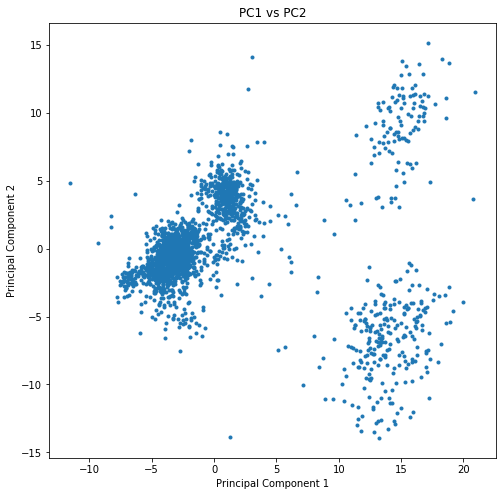

In [20]:
pca.n_components = 2
transformed = pca.fit_transform(scaled_cutouts)

_ = plt.figure(figsize=(8,8))
_ = plt.plot(transformed[:,0], transformed[:,1],'.')
_ = plt.xlabel('Principal Component 1')
_ = plt.ylabel('Principal Component 2')
_ = plt.title('PC1 vs PC2')

plt.show()

Here we can see 4 quite well defined clusters in the dataset. Out of curiosity, we can also test what happens if we take the first 3 PCs instead of 2 (although this makes the visualization a bit more tricky):

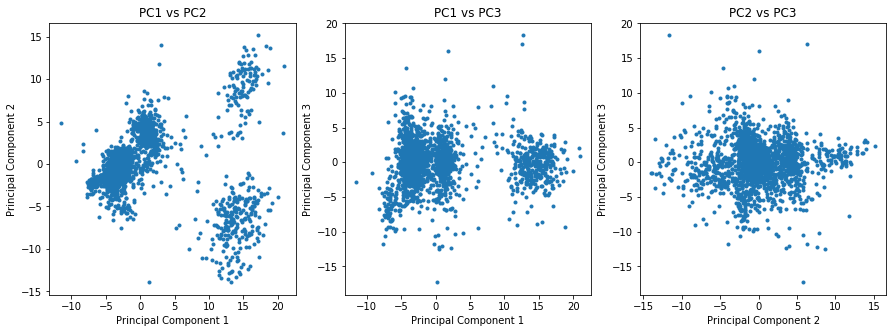

In [21]:
pca.n_components = 3
transformed_3d = pca.fit_transform(scaled_cutouts)

_ = plt.figure(figsize=(15,5))
_ = plt.subplot(1, 3, 1)
_ = plt.plot(transformed_3d[:,0], transformed_3d[:,1],'.')
_ = plt.xlabel('Principal Component 1')
_ = plt.ylabel('Principal Component 2')
_ = plt.title('PC1 vs PC2')
_ = plt.subplot(1, 3, 2)
_ = plt.plot(transformed_3d[:,0], transformed_3d[:,2],'.')
_ = plt.xlabel('Principal Component 1')
_ = plt.ylabel('Principal Component 3')
_ = plt.title('PC1 vs PC3')
_ = plt.subplot(1, 3, 3)
_ = plt.plot(transformed_3d[:,1], transformed_3d[:,2],'.')
_ = plt.xlabel('Principal Component 2')
_ = plt.ylabel('Principal Component 3')
_ = plt.title('PC2 vs PC3')
plt.show()

## Clustering

Now to the final step: Finding clusters in the feature space and assigning each spike to its closest cluster. There are [many, many](https://scikit-learn.org/stable/modules/clustering.html) clustering algorithms out there, but we will use a very simple one: A Gaussian Mixture Model ([GMM](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture)). Of course, GMMs have their drawbacks (number of clusters must be specified, many parameters to fit, don't scale very well), but for our case they might be sufficient.

Judging from our plot, 4 clusters might be sufficient as a description of the data. The initialization of a GMM can have a lot of influence on the output, so it is possible that you need to fit the GMM multiple times in order to find a good fit.

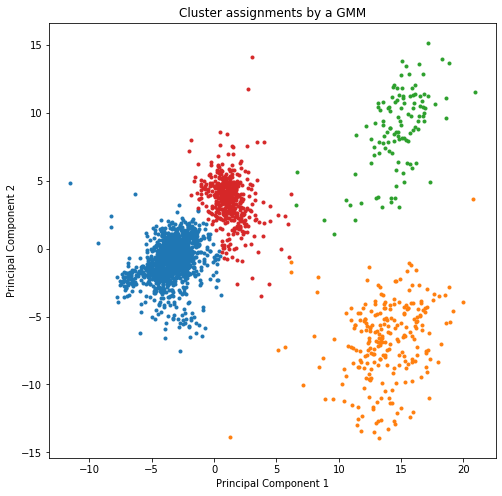

In [23]:
n_components = 4
gmm = GaussianMixture(n_components=n_components, n_init=10)
labels = gmm.fit_predict(transformed)

_ = plt.figure(figsize=(8,8))
for i in range(n_components):
    idx = labels == i
    _ = plt.plot(transformed[idx,0], transformed[idx,1],'.')
    _ = plt.title('Cluster assignments by a GMM')
    _ = plt.xlabel('Principal Component 1')
    _ = plt.ylabel('Principal Component 2')
    _ = plt.axis('tight')
plt.show()

Once we've found a sensible clustering, we can now go back and check the waveforms in the different clusters

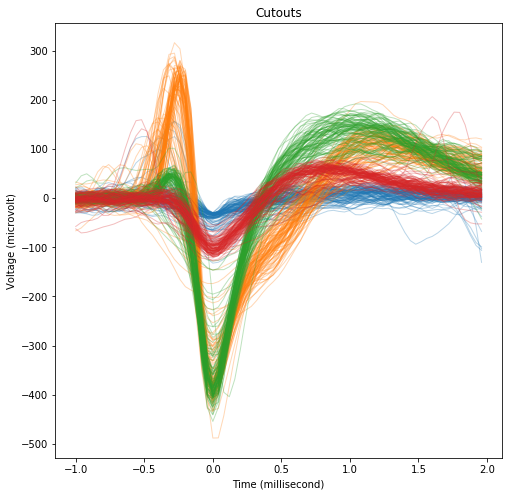

In [24]:
_ = plt.figure(figsize=(8,8))
for i in range(n_components):
    idx = labels == i
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
    plot_waveforms(cutouts[idx,:], fs, pre, post, n=100, color=color, show=False)
plt.show()

This concludes this short tutorial on neuronal data analysis with the McsPyDataTools package.